In [1]:
using FredData
using TimeSeries
using Gadfly
using Distributions

INFO: Precompiling module FredData.
ERROR: LoadError: error compiling __init__: error compiling __init_streaming__: error compiling get_default_tls_config: error compiling Type: could not load library "C:\Users\Daniel\.julia\v0.6\MbedTLS\src\..\deps\usr\bin\libmbedtls.dll"
The specified procedure could not be found.

Stacktrace:
 [1] include_from_node1(::String) at .\loading.jl:576
 [2] include(::String) at .\sysimg.jl:14
 [3] anonymous at .\<missing>:2
while loading C:\Users\Daniel\.julia\v0.6\Requests\src\Requests.jl, in expression starting on line 419
ERROR: LoadError: Failed to precompile Requests to C:\Users\Daniel\.julia\lib\v0.6\Requests.ji.
Stacktrace:
 [1] compilecache(::String) at .\loading.jl:710
 [2] _require(::Symbol) at .\loading.jl:463
 [3] require(::Symbol) at .\loading.jl:405
 [4] include_from_node1(::String) at .\loading.jl:576
 [5] include(::String) at .\sysimg.jl:14
 [6] anonymous at .\<missing>:2
while loading C:\Users\Daniel\.julia\v0.6\FredData\src\FredData.jl, i

LoadError: [91mFailed to precompile FredData to C:\Users\Daniel\.julia\lib\v0.6\FredData.ji.[39m

In [2]:
type ARp
    c
    ϕ
    σ2
end

In [3]:
ar = ARp(0, [0.90, 0.05], 1.)

ARp(0, [0.9, 0.05], 1.0)

In [4]:
function simulate(ar::ARp, T, Tburn)
    # alternative: starting values from stationary distribution!
    p = length(ar.ϕ)
    y = zeros(T+Tburn+p)
    for t=1:T+Tburn
        y[p+t] = ar.c + y[p+t-1:-1:t]'*ar.ϕ + sqrt(ar.σ2)*randn()
    end
    return y[p+Tburn+1:end]
end

simulate (generic function with 1 method)

In [5]:
T1  = 200
hor = 20
T_all = T1 + hor
y_all = simulate(ar, T_all, 1000)
y1 = y_all[1:T1]
plot(x=1:T_all, y=y_all, Geom.line)

LoadError: [91mUndefVarError: plot not defined[39m

In [6]:
p = length(ar.ϕ)

α_prior = 1
θ_prior = 1

y = y1[p+1:end]
X = hcat([y1[p+1-i:T1-i] for i=1:p]...)

T = T1-p

S = 10000

c_all  = zeros(S)
ϕ_all  = zeros(S, p)
σ2_all = zeros(S)
yf_all = zeros(S, hor)

c  = 0
ϕ  = zeros(p)
σ2 = 1

for s=1:S
    
    μc  = sum(y-X*ϕ)/T
    σ2c = σ2/T
    c   = rand(Normal(μc, sqrt(σ2c)))
    
    hϕ = X'*(y-c)/σ2
    Jϕ = X'*X/σ2
    ϕ  = rand(MvNormalCanon(hϕ, Jϕ))
    # reject nonstationary solutions!!
        
    u  = y - c - X*ϕ
    α  = α_prior + T/2
    θ  = θ_prior + u'*u/2
    σ2 = rand(InverseGamma(α, θ))
    
    yall = [y1; zeros(hor)]
    for h=1:hor
        yall[T1+h] = c + yall[T1+h-1:-1:T1+h-p]'*ϕ + sqrt(σ2)*randn()
    end
    yf = yall[T1+1:end]
    
    c_all[s]   = c
    ϕ_all[s,:] = ϕ
    σ2_all[s]  = σ2
    yf_all[s,:]  = yf
    
end

LoadError: [91mUndefVarError: Normal not defined[39m

In [7]:
plot(x=1:1000, y=σ2_all[1:1000,1], Geom.line)

LoadError: [91mUndefVarError: plot not defined[39m

In [8]:
plot(x=σ2_all, Geom.histogram)

LoadError: [91mUndefVarError: plot not defined[39m

In [9]:
plot(x=yf_all[:,1], Geom.histogram)

LoadError: [91mUndefVarError: plot not defined[39m


## mixture-of-parameters estimator for computing the log-score

KDE for calculating the log-score is not a good idea!
(see Lerch et al.: "Probabilistic forecasting based on MCMC output")

In [108]:
mean(-logpdf.(Normal.(c_all+ϕ_all*y1[T1:-1:T1+1-p], σ2_all), y_all[T1+1]))

1.026605674416381

In [109]:
-logpdf.(Normal(mean(yf_all[:,1]),std(yf_all[:,1])), y_all[T1+1])

1.0689998492563164

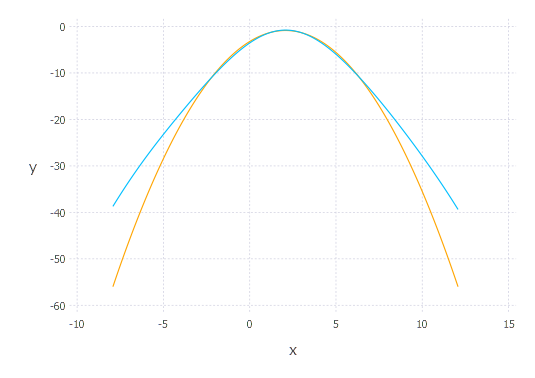

In [107]:
xl = mean(yf_all[:,1]) + (-10:0.01:10)
plot(
    layer(x=xl, y=[log(mean(pdf.(Normal.(c_all+ϕ_all*y1[T1:-1:T1+1-p], σ2_all), x))) for x=xl], Geom.line),
    layer(x=xl, y=logpdf.(Normal(mean(yf_all[:,1]),std(yf_all[:,1])),xl), Geom.line, Theme(default_color="orange"))
    )

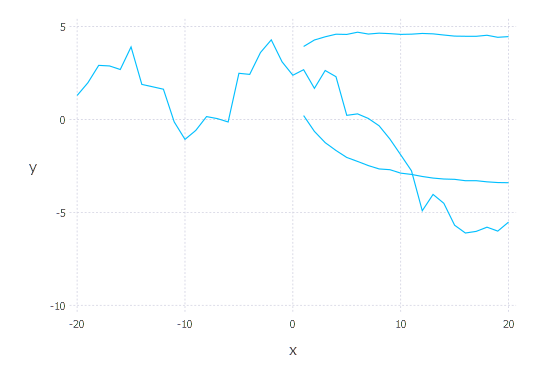

In [63]:
plot(
    layer(x=-20:20, y=y_all[T1-20:T1+hor], Geom.line),
    layer(x=1:20, y=[quantile(yf_all[:,i], 0.975) for i=1:hor], Geom.line),
    layer(x=1:20, y=[quantile(yf_all[:,i], 0.025) for i=1:hor], Geom.line)
    )